In [1]:
import sys
sys.path.append('/home/hwang/anaconda3/lib/python3.7/site-packages/')

from sklearn import datasets
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import nibabel
import math
import texture

from keras.utils.np_utils import to_categorical
from keras import optimizers 
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Lambda, Reshape, AveragePooling2D, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.applications.resnet50 import ResNet50, decode_predictions

from keras import backend as K
from keras.utils import plot_model

from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint 
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from keras_unet.utils import plot_imgs, get_augmented, plot_segm_history
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance 
from keras_unet.models import custom_unet

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# import pcanet as net 

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

-----------------------------------------
keras-unet init: TF version is < 2.0.0 or not present - using `Keras` instead of `tf.keras`
-----------------------------------------


In [85]:
# delete .DS_Store file in each folder 

# resample
            
resampath = '/Users/hwang/Documents/research/2_Prostate/Unet/roi_ADC/PzTz_resamp/'

resampfile = os.listdir(resampath)
resampfile.sort()
num_seg = len(resampfile)
count_seg = 0
for item_resamp in os.listdir(resampath):
    current_resamp = os.path.basename(item_resamp)
    if current_resamp == '.DS_Store':
        fullpath = os.path.join(resampath,current_resamp)
        os.remove(fullpath) 

In [86]:
# resample original image 

imgpath = '/Users/hwang/Documents/research/2_Prostate/Unet/roi_ADC/PzTz_resamp/'
imgfile = os.listdir(imgpath)
imgfile.sort()

resampath = '/Users/hwang/Documents/research/2_Prostate/Unet/roi_ADC/PzTz_resamp_final/'

i = sitk.ReadImage(os.path.join(imgpath,imgfile[1]))
sitk.WriteImage(i, os.path.join(resampath,imgfile[1]))
num_img = len(imgfile)

num = 0

for item in os.listdir(imgpath):
   
    j = sitk.ReadImage(os.path.join(imgpath,imgfile[num]))

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(j)
    # resampler.SetOrigin(j.GetOrigin())
    # resampler.SetDirection(j.GetDirection())
    resampler.SetDefaultPixelValue(j.GetPixelIDValue())
    resampler.SetSize(i.GetSize())
    resampler.SetSize([192, 192, 22])
    resampler.SetOutputSpacing(j.GetSpacing())
    resampled = resampler.Execute(j)
    
    resampfile = os.path.basename(imgfile[num])
    sitk.WriteImage(resampled, os.path.join(resampath,resampfile))
    
    if num < num_img-1:
        num = num + 1

In [240]:
# resample mask image 

maskpath = '/Users/hwang/Documents/research/2_Prostate/Unet/roi_ADC/PzTz_resamp/'
maskfile = os.listdir(maskpath)
maskfile.sort()

mresampath = '/Users/hwang/Documents/research/2_Prostate/Unet/roi_ADC/PzTz_resamp_final/'

k = sitk.ReadImage(os.path.join(maskpath,maskfile[1]))
sitk.WriteImage(k, os.path.join(mresampath,maskfile[1]))
num_mask = len(maskfile)

num = 0

for mitem in os.listdir(maskpath):
   
    l = sitk.ReadImage(os.path.join(maskpath,maskfile[num]))

    mresampler = sitk.ResampleImageFilter()
    mresampler.SetReferenceImage(l)
    mresampler.SetDefaultPixelValue(l.GetPixelIDValue())
    mresampler.SetSize(k.GetSize())
    mresampler.SetOutputSpacing(l.GetSpacing())
    mresampled = mresampler.Execute(l)
    
    mresampfile = os.path.basename(maskfile[num])
    sitk.WriteImage(mresampled, os.path.join(mresampath,mresampfile))
    
    if num < num_mask-1:
        num = num + 1

In [87]:
# convert 

mresampath = '/Users/hwang/Documents/research/2_Prostate/Unet/roi_ADC/PzTz_resamp/'
maskfile = os.listdir(mresampath)
maskfile.sort()
num_mask = len(maskfile)

resampath = '/Users/hwang/Documents/research/2_Prostate/Unet/roi_ADC/PzTz_resamp_final/'

num = 0

for mitem in os.listdir(mresampath):
    
    mask = sitk.ReadImage(os.path.join(mresampath,maskfile[num]))
    # m = sitk.GetArrayFromImage(mask)
    for k in range(mask.GetSize()[2]):
        for i in range(mask.GetSize()[0]):
            for j in range(mask.GetSize()[1]):
                if mask[i,j,k] > 1:
                    mask[i,j,k] = 0
                    
    sitk.WriteImage(mask,os.path.join(resampath,maskfile[num]),True)
    
    if num < num_mask-1:
        num = num + 1

In [3]:
# delete .DS_Store file in each folder 

# resample
            
resampath = '/Users/hwang/Desktop/research/3_tumor/mask_final/'

resampfile = os.listdir(resampath)
resampfile.sort()
num_seg = len(resampfile)
count_seg = 0
for item_resamp in os.listdir(resampath):
    current_resamp = os.path.basename(item_resamp)
    if current_resamp == '.DS_Store':
        fullpath = os.path.join(resampath,current_resamp)
        os.remove(fullpath) 

In [4]:
# feature for deep learning (2D): img

resampath = '/Users/hwang/Desktop/research/3_tumor/ADC_resamp/'
resampfile = os.listdir(resampath)
resampfile.sort()
num_img = len(resampfile)

first = sitk.ReadImage(os.path.join(resampath,resampfile[0]))
feature = sitk.GetArrayFromImage(first) 
feature_reshape = feature.transpose(1,2,0)

num = 1

for n in os.listdir(resampath):

    i = sitk.ReadImage(os.path.join(resampath,resampfile[num]))
    j = sitk.GetArrayFromImage(i)
    j_reshape = j.transpose(1,2,0)
    feature_reshape = np.dstack((feature_reshape, j_reshape))
    
    if num < num_img-1:
        num = num + 1    

In [5]:
# feature normalization: 0-1

maxval = np.amax(feature)
feature_norm = feature_reshape/maxval

In [6]:
# feature for deep learning (2D): multiple slices 

resampath = '/Users/hwang/Desktop/research/3_tumor/mask_final/'
resampfile = os.listdir(resampath)
resampfile.sort()
num_img = len(resampfile)

first = sitk.ReadImage(os.path.join(resampath,resampfile[0]))
mask = sitk.GetArrayFromImage(first) 
mask_reshape = mask.transpose(1,2,0)

num = 1

for n in os.listdir(resampath):

    i = sitk.ReadImage(os.path.join(resampath,resampfile[num]))
    j = sitk.GetArrayFromImage(i)
    j_reshape = j.transpose(1,2,0)
    mask_reshape = np.dstack((mask_reshape, j_reshape))
    
    if num < num_img-1:
        num = num + 1   

In [7]:
X = feature_norm.copy()
XX = feature_norm.copy()
XXX = feature_norm.copy()

list_matrix = [X,XX,XXX]

y = np.stack(list_matrix,axis=3)
feature_reshape = y.transpose(2,0,1,3)
mask_reshape = mask_reshape.transpose(2,0,1)
mask_reshape = mask_reshape.reshape((mask_reshape.shape[0],mask_reshape.shape[1],mask_reshape.shape[2],1))

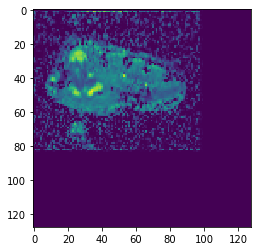

In [12]:
im = plt.imshow(feature_reshape[150,:,:,0])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(feature_reshape, mask_reshape, test_size = 0.3, random_state = 10)

In [14]:
train_gen = get_augmented(X_train, y_train, batch_size = 16, data_gen_args = dict(rotation_range=5., width_shift_range = 0.05, height_shift_range = 0.05, shear_range = 40, zoom_range = 0.2, horizontal_flip = True, vertical_flip = True, fill_mode = 'constant'))
sample_batch = next(train_gen)
xx, yy = sample_batch
input_shape = X_train[0].shape

model = custom_unet(input_shape, filters = 32, use_batch_norm = True, dropout = 0.3, dropout_change_per_layer = 0.0, num_layers = 4)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
spatial_dropout2d_1 (

In [15]:
model_filename = 'segm_model_v3.h5'
callback_checkpoint = ModelCheckpoint(model_filename,verbose=1,monitor='val_loss', save_best_only=True)
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = [iou, iou_thresholded])
history = model.fit_generator(train_gen, steps_per_epoch = 200, epochs = 200, validation_data = (X_test, y_test), callbacks = [callback_checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
200/200 [==============================] - 744s 4s/step - loss: 0.3769 - iou: 0.0163 - iou_thresholded: 0.0248 - val_loss: 0.1209 - val_iou: 0.0144 - val_iou_thresholded: 7.6401e-04

Epoch 00001: val_loss improved from inf to 0.12094, saving model to segm_model_v3.h5
Epoch 2/200
200/200 [==============================] - 1427s 7s/step - loss: 0.0865 - iou: 0.0292 - iou_thresholded: 0.0051 - val_loss: 0.1590 - val_iou: 4.1668e-04 - val_iou_thresholded: 7.6401e-04

Epoch 00002: val_loss did not improve from 0.12094
Epoch 3/200
200/200 [==============================] - 1140s 6s/step - loss: 0.0570 - iou: 0.0470 - iou_thresholded: 0.0098 - val_loss: 0.0489 - val_iou: 0.0869 - val_iou_thresholded: 0.1003

Epoch 00003: val_loss improved from 0.12094 to 0.04888, saving model to segm_model_v3.h5
Epoch 4/200
200/200 [==============================] - 888s 4s/step - loss: 0.0492 - iou: 0.0656 - iou_thresholded: 0.0286 - val_loss: 0.038

In [16]:
model.load_weights(model_filename)
y_pred = model.predict(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

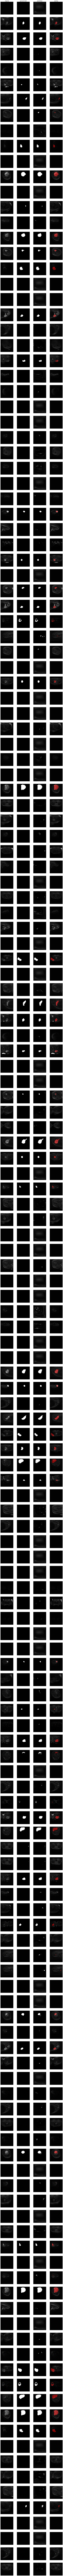

In [293]:
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=300)

In [17]:
def dice_coef2(y_test, y_pred):
    y_test_f = y_test.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_test_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_test_f * y_pred_f)
    return 2. * intersection / union

In [18]:
dice_coef2(y_test, y_pred)

0.3309746356665688